# Caching

How many price requests could be cached (have same pickup and return location, source country and driver age) for 1 hour, 3 hours, 12 hours? Per contractor.

Graphs show - at full hours (ex. every 3 hours, every 12 hours). What portion of the requests have duplicated parameters (per broker_contract_id) in the last 1,3,12 hours. After having got data by broker_contract_id it is aggregated into broker data in whole.

Note that for these graphs we have already removed duplicate request_uuid.

Currently some graphs look weird because we only look at every 1 hour or every 3 hours or every 12 hours..

In second case we also force return_timestamp and pickup_timestamp to also be the same.

## Investigating maximum cacheability.

From request data see how many responses are exactly the same.

To start we'll investigate "Charge_log" column

In [1]:
import pandas as pd
import csv
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 6)
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [134]:
fields = ["pickup_timestamp", "timestamp", 
          "source_country_region_id", "driver_age", "rental_days",
         "broker_contract_id", "pickup_desk_id", "return_desk_id"]
df = pd.read_csv("rate_quote.csv", skipinitialspace=True, usecols=fields)

In [2]:
start_size = len(df)
print(start_size)


2997586


In [3]:
grouped = df.groupby("charge_log")

In [34]:
with open("test.op", "w") as f:
    i = 0
    for group in grouped:
        for g in group[1].itertuples():
            f.write(str(g) +"\n")
        i += 1
        f.write("\n")
        if i == 30:
            break


In [4]:
# Keeps first of each duplicate
dropped = df.drop_duplicates("charge_log")

In [5]:
len(dropped)
cached_percentage = 100 - len(dropped)/start_size*100
print("Percentage of duplicate responses is {}".format(cached_percentage))

Percentage of duplicate responses is 99.12509599390977


## Investigating how many same (location, source country, driver age, pickup, dropff) 

1) Can make a line graph again with y-values being % of same location, source country, driver age in 1 hour frame.. For all hours? 5-minutes intervals? In a day.

 same pickup and return location, source country and driver age
 
 
 

### Grouping by 1 hour.

    Questions: Does it matter for which day the price requests are made for? Ex. pickup_timestamp and return_timestamp?
    
Should be done for unfiltered data


In [61]:

fields = ["timestamp", "driver_age", "source_country_region_id", "pickup_desk_id", "return_desk_id", "return_timestamp", "pickup_timestamp"]
df_new = pd.read_csv("rate_quote.csv", skipinitialspace=True, usecols=fields)
df_new["timestamp"] = pd.to_datetime(df_new['timestamp'])
df_new["pickup_timestamp"] = pd.to_datetime(df_new['pickup_timestamp'])
df_new["return_timestamp"] = pd.to_datetime(df_new['return_timestamp'])



In [62]:
df_new = df_new.set_index("timestamp")
df_new_groups = df_new.groupby(pd.Grouper(freq='60Min'))

In [68]:
fields = ["timestamp", "pickup_timestamp", "return_timestamp", "broker_contract_id", 
          "source_country_region_id", "driver_age", "pickup_desk_id", "return_desk_id", "rental_days",
         "Broker_name"]
df_dups = pd.read_csv("rate_quote_1_dup2.csv", skipinitialspace=True, usecols=fields)
print(df_dups.shape)

df_dups["timestamp"] = pd.to_datetime(df_dups['timestamp'])
df_dups["pickup_timestamp"] = pd.to_datetime(df_dups['pickup_timestamp'])
df_dups["return_timestamp"] = pd.to_datetime(df_dups['return_timestamp'])

(130915, 10)


In [9]:
df_new_dups = df_dups.set_index("timestamp")
df_new_dups = df_new_dups.groupby(pd.Grouper(freq='60Min'))

### Look at three different cases

1) source, pickup, return, driver age same

2) source, pickup, return, driver age, same pickup_timestamp, same return_timestamp

3) 3rd case pickup day, driver age, pickup location, drop location, rental days length
-- for broker contract id all..

In [189]:
from collections import defaultdict
by_contract_id = defaultdict(list)


total = 0
by_hour = []
total_by_hour = []
for group in df_new_dups:
    # Group by broker_contract_id
    in_group_cache_total = 0
    for g in group[1].groupby(["broker_contract_id"]):
        non_dup = g[1].drop_duplicates(["driver_age", "source_country_region_id", "pickup_desk_id", "return_desk_id"])
        in_group_cache = len(g[1]) - len(non_dup)
        in_group_cache_total += in_group_cache
        by_contract_id[g[0]].append((group[0],in_group_cache,len(g[1])))
    by_hour.append(in_group_cache_total)
    total_by_hour.append(len(group[1]))
    total += len(group[1])

In [184]:
print(total)
print(sum(by_hour))
proportion = [by_hour[i]/total_by_hour[i] for i in range(len(by_hour))]
print(proportion)

from pprint import pprint

130915
107017
[0.8435603506405934, 0.8458669981354879, 0.8398203592814372, 0.8628318584070797, 0.8204887218045113, 0.8408007626310772, 0.8058864751226349, 0.7594306049822064, 0.7953151143335192, 0.8084004602991944, 0.7411300919842313, 0.8110275689223058, 0.806438127090301, 0.7751540041067762, 0.8053539019963702, 0.8006773101112724, 0.8303078137332282, 0.8235815602836879, 0.8132611637347767, 0.8451612903225807, 0.8545900490539594, 0.8298582151793161, 0.8109826589595376, 0.797683923705722, 0.831081081081081, 0.8299430431244914, 0.7524071526822559, 0.8034610630407911, 0.841340782122905, 0.8181818181818182, 0.6988372093023256, 0.7374749498997996, 0.7585114806017419, 0.7820593809222994, 0.7549627791563276, 0.7919571045576408, 0.8148546824542519, 0.8060475161987041, 0.8069096071935636, 0.815195884447962, 0.8106817194963092, 0.8243075651095494, 0.822051074179165, 0.8381452318460193, 0.8481735159817352, 0.8340909090909091, 0.7931937172774869, 0.7704225352112676, 0.7453476983349657, 0.845875542

### Merge data by contractor







In [2]:
# Merge with broker contract name
fields = ["Contract_ID", "Contract_name", "Broker name"]
contract_df = pd.read_csv("broker_contracts.csv", skipinitialspace=True, usecols=fields)
# This holds contract names and which broker name corresponds to each contract id..
#contract_df = contract_df.set_index("Contract_ID")

print(contract_df.shape)
print(contract_df.dtypes)

from collections import defaultdict

broker_contract_ids = defaultdict(set)
for row in contract_df.itertuples():
    #print(row)
    broker_contract_ids[row[3]].add(row[1])
    
    
print(broker_contract_ids)

(27, 3)
Contract_ID       int64
Contract_name    object
Broker name      object
dtype: object
defaultdict(<class 'set'>, {'CDM-AE-CR': {3, 4}, 'SupplierWebsite': {24, 25, 23}, 'CarTrawler': {26, 27, 28}, 'Online Republic': {6, 7}, 'Skyscanner': {22}, 'Flexible Autos': {20, 21}, 'Clarify Car Hire': {14, 15}, 'RateChain test': {1}, 'Zuzuche': {29, 30}, 'Atlantic Choice': {8, 9}, 'BSP Auto': {12, 13}, 'FTI': {11}, 'TravelJigsaw': {16, 17, 18, 19}})


In [214]:
merged_data = defaultdict(dict)

for contractor in broker_contract_ids.keys():
    for key in broker_contract_ids[contractor]:
        if contractor not in merged_data:
            for i, k in enumerate(by_contract_id[key]):
                if k[0] in merged_data[contractor]:
                    merged_data[contractor][k[0]][0] += k[1]
                    merged_data[contractor][k[0]][1] += k[2]
                    
                else:
                    merged_data[contractor][k[0]] =  [k[1], k[2]]
                
        

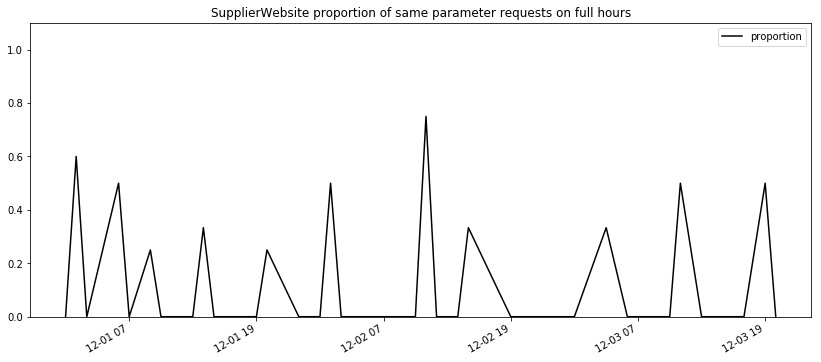

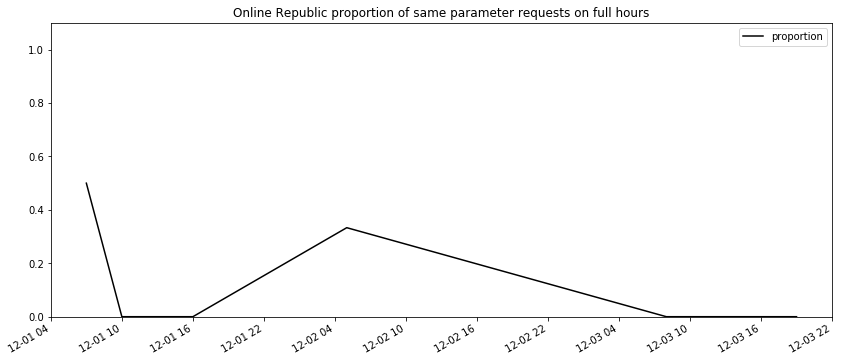

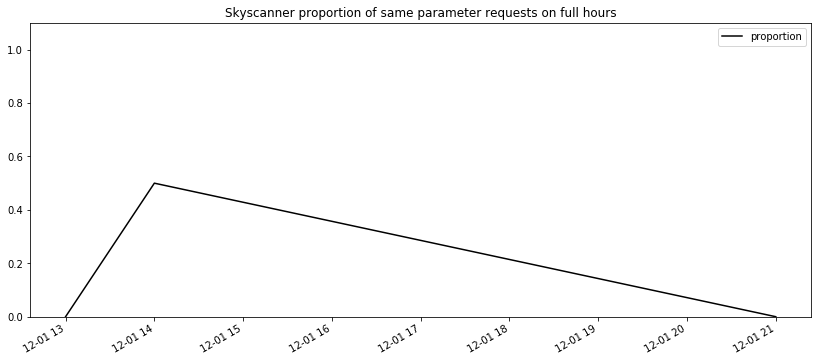

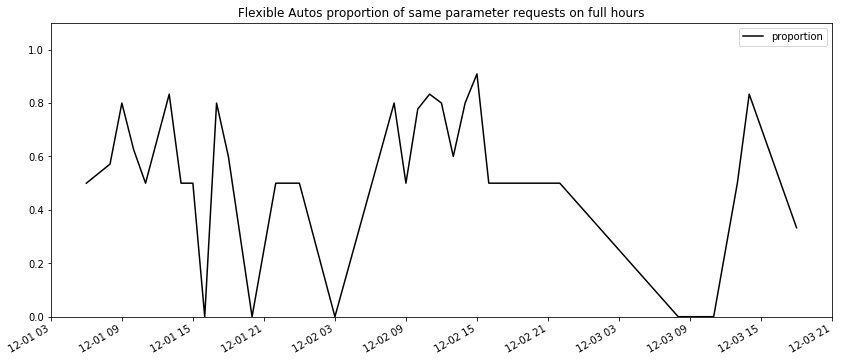

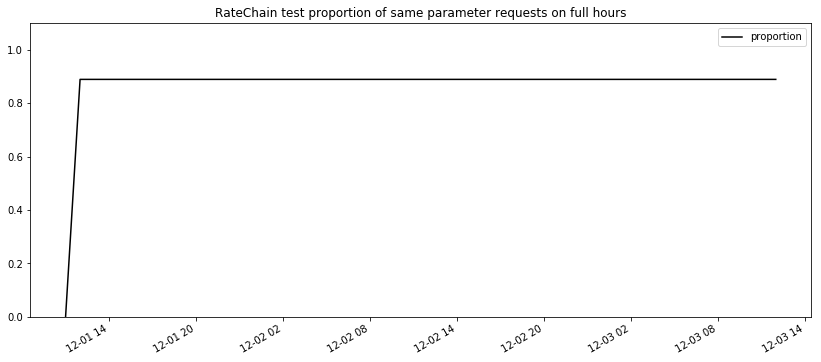

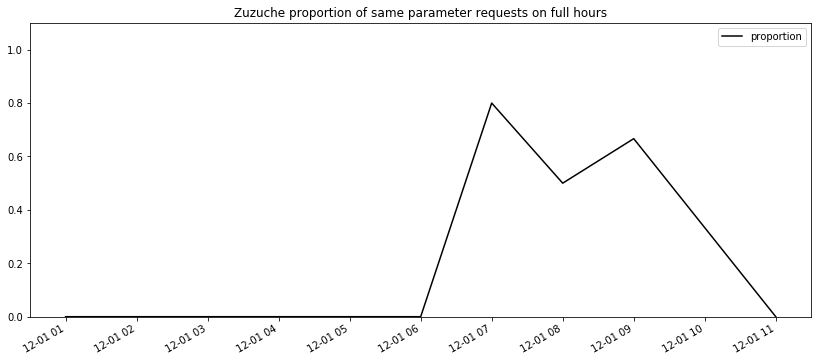

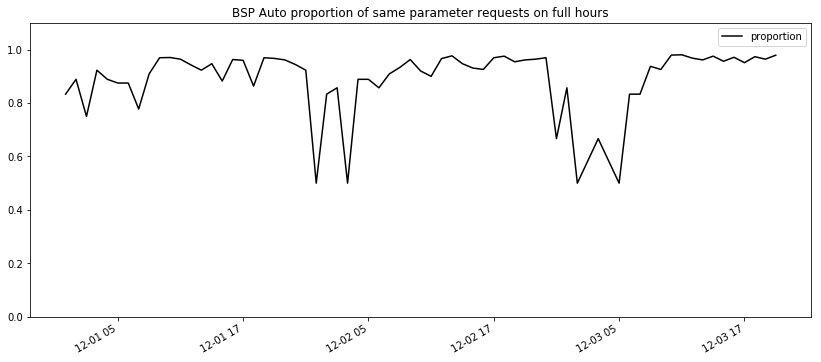

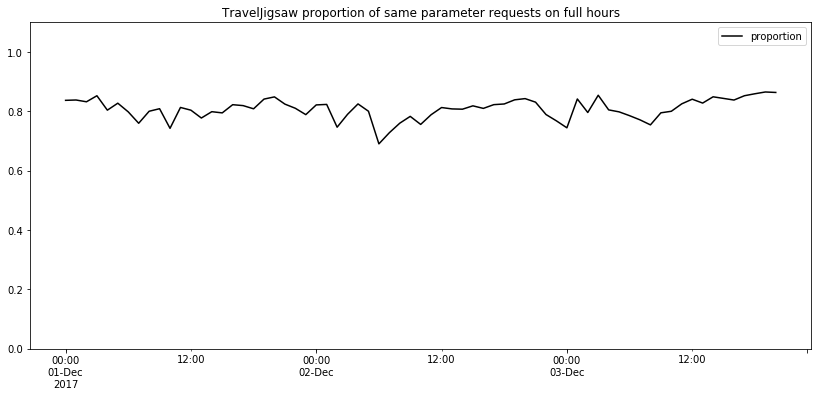

In [240]:

for contractor in broker_contract_ids.keys():
    tJig = pd.DataFrame(merged_data[contractor]).T
    if (merged_data[contractor]):
        tJig["proportion"] = tJig[0]/tJig[1]
        tPlot = tJig.plot(y="proportion", title=contractor + " proportion of same parameter requests on full hours", kind="line", colormap="gist_gray")#, width=0.75)
        tPlot.set_ylim(0, 1.1)




### 3 hours.. 12 hours

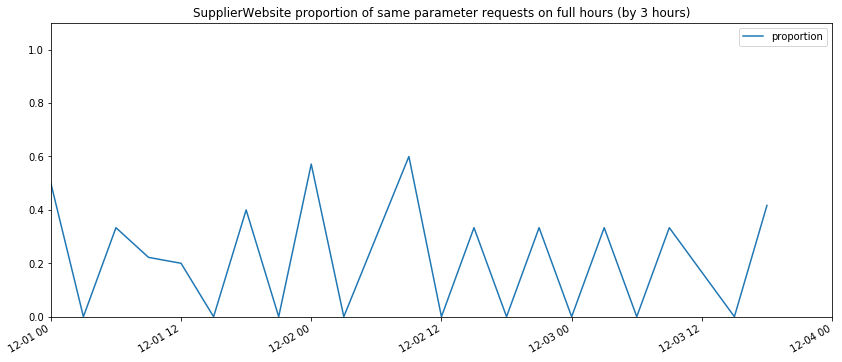

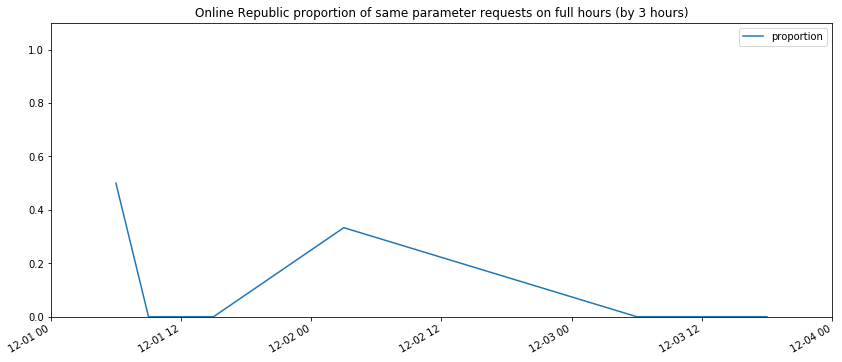

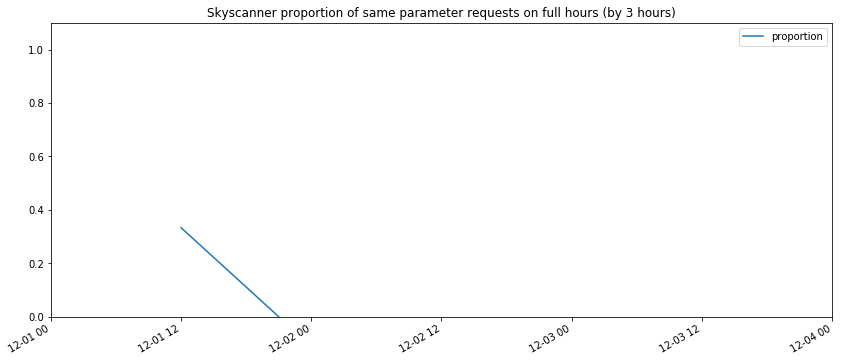

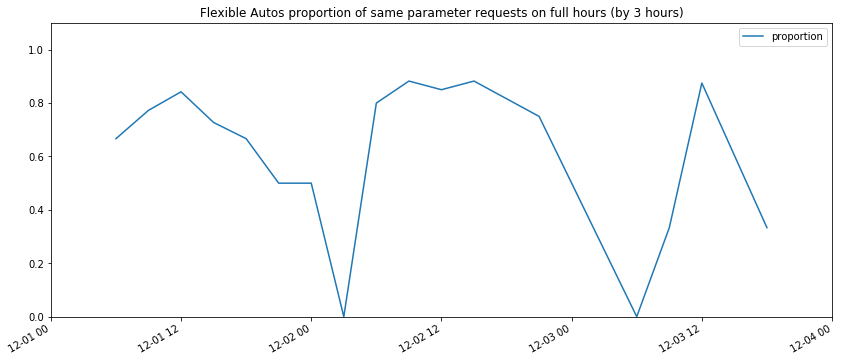

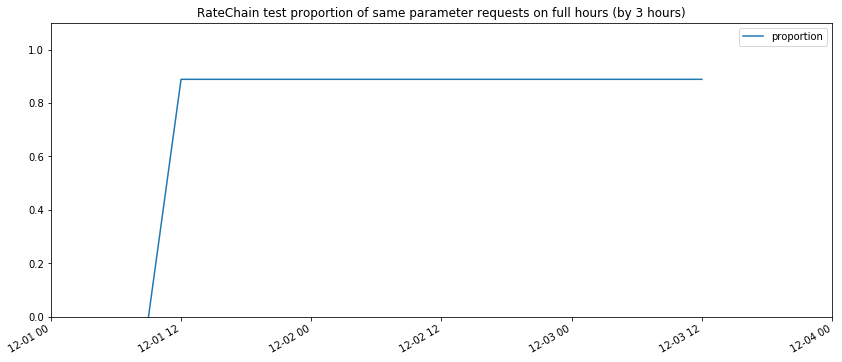

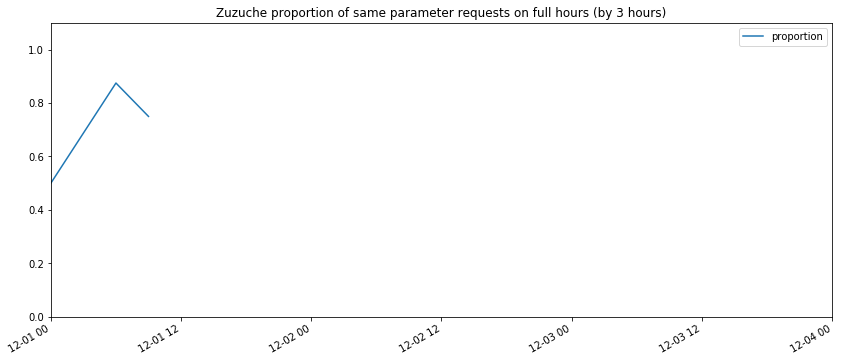

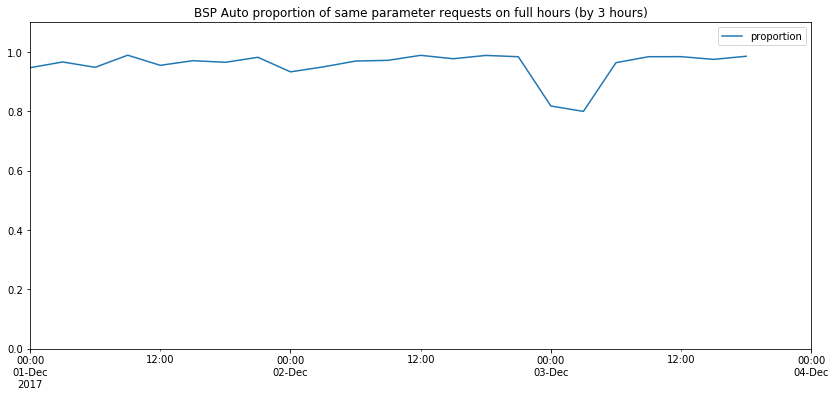

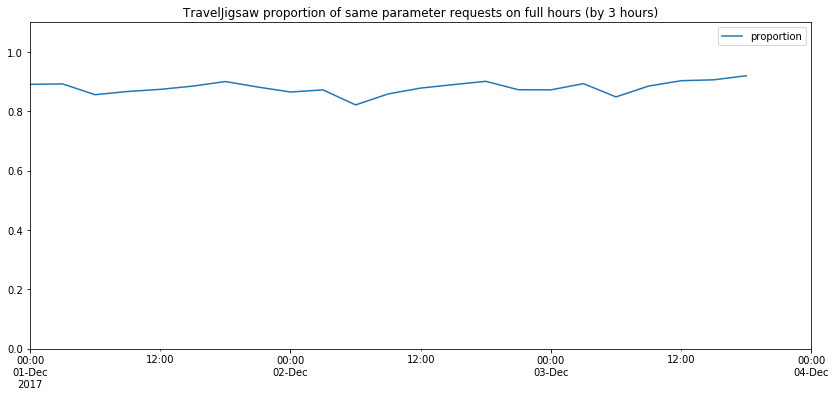

In [247]:
# 3 hours
df_new_dups_2 = df_dups.set_index("timestamp")
df_new_dups_2 = df_new_dups_2.groupby(pd.Grouper(freq='180Min'))


by_contract_id = defaultdict(list)
total = 0
by_hour = []
total_by_hour = []


for group in df_new_dups_2:
    # Group by broker_contract_id
    in_group_cache_total = 0
    for g in group[1].groupby(["broker_contract_id"]):
        non_dup = g[1].drop_duplicates(["driver_age", "source_country_region_id", "pickup_desk_id", "return_desk_id"])
        in_group_cache = len(g[1]) - len(non_dup)
        in_group_cache_total += in_group_cache
        by_contract_id[g[0]].append((group[0],in_group_cache,len(g[1])))
    by_hour.append(in_group_cache_total)
    total_by_hour.append(len(group[1]))
    total += len(group[1])
    
    

merged_data = defaultdict(dict)
for contractor in broker_contract_ids.keys():
    for key in broker_contract_ids[contractor]:
        if contractor not in merged_data:
            for i, k in enumerate(by_contract_id[key]):
                if k[0] in merged_data[contractor]:
                    merged_data[contractor][k[0]][0] += k[1]
                    merged_data[contractor][k[0]][1] += k[2]
                    
                else:
                    merged_data[contractor][k[0]] =  [k[1], k[2]]
                
        
        
        
        

for contractor in broker_contract_ids.keys():
    tJig = pd.DataFrame(merged_data[contractor]).T
    if (merged_data[contractor]):
        tJig["proportion"] = tJig[0]/tJig[1]
        tPlot = tJig.plot(y="proportion", title=contractor + " proportion of same parameter requests on full hours (by 3 hours)", kind="line")#, width=0.75)
        tPlot.set_ylim(0, 1.1)
        tPlot.set_xlim(pd.to_datetime("2017-12-01"), pd.to_datetime("2017-12-04"))


In [141]:
print(total)
print(sum(by_hour))
from pprint import pprint
pprint(by_contract_id.keys())
pprint(by_contract_id[21])

130915
116048
dict_keys([13, 16, 17, 18, 23, 24, 25, 29, 6, 7, 21, 1, 22])
[(Timestamp('2017-12-01 06:00:00', freq='180T'), 6),
 (Timestamp('2017-12-01 09:00:00', freq='180T'), 17),
 (Timestamp('2017-12-01 12:00:00', freq='180T'), 16),
 (Timestamp('2017-12-01 15:00:00', freq='180T'), 8),
 (Timestamp('2017-12-01 18:00:00', freq='180T'), 4),
 (Timestamp('2017-12-01 21:00:00', freq='180T'), 1),
 (Timestamp('2017-12-02 00:00:00', freq='180T'), 1),
 (Timestamp('2017-12-02 03:00:00', freq='180T'), 0),
 (Timestamp('2017-12-02 06:00:00', freq='180T'), 4),
 (Timestamp('2017-12-02 09:00:00', freq='180T'), 15),
 (Timestamp('2017-12-02 12:00:00', freq='180T'), 17),
 (Timestamp('2017-12-02 15:00:00', freq='180T'), 15),
 (Timestamp('2017-12-02 21:00:00', freq='180T'), 3),
 (Timestamp('2017-12-03 06:00:00', freq='180T'), 0),
 (Timestamp('2017-12-03 09:00:00', freq='180T'), 1),
 (Timestamp('2017-12-03 12:00:00', freq='180T'), 7),
 (Timestamp('2017-12-03 18:00:00', freq='180T'), 1)]


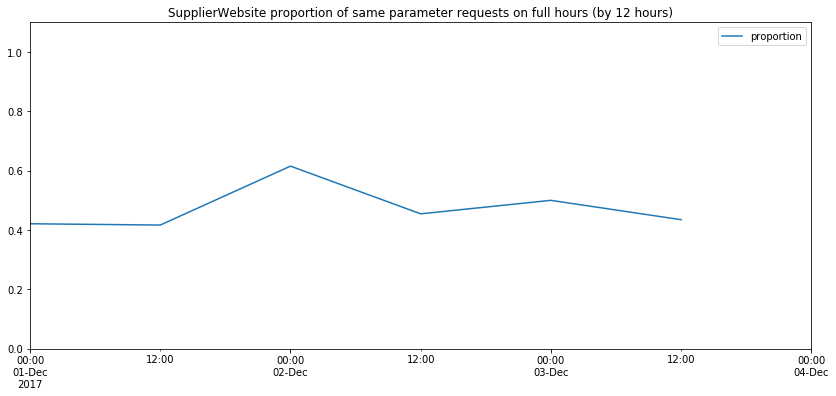

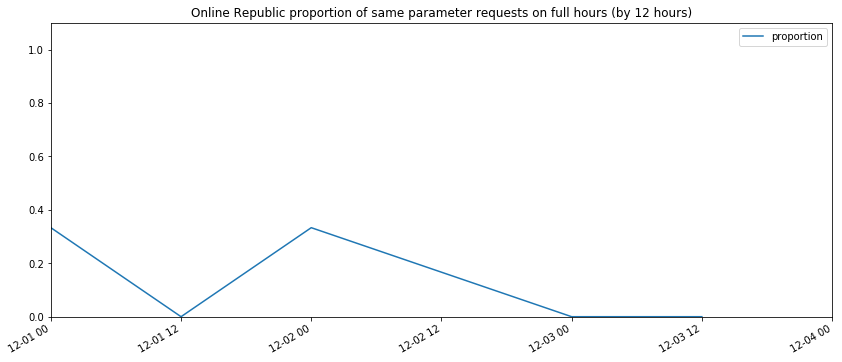

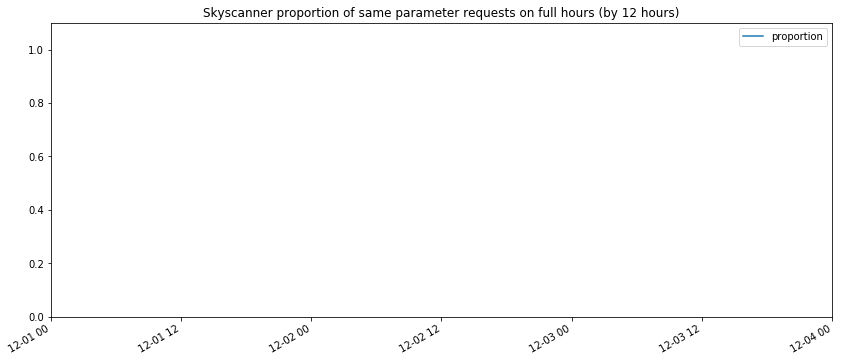

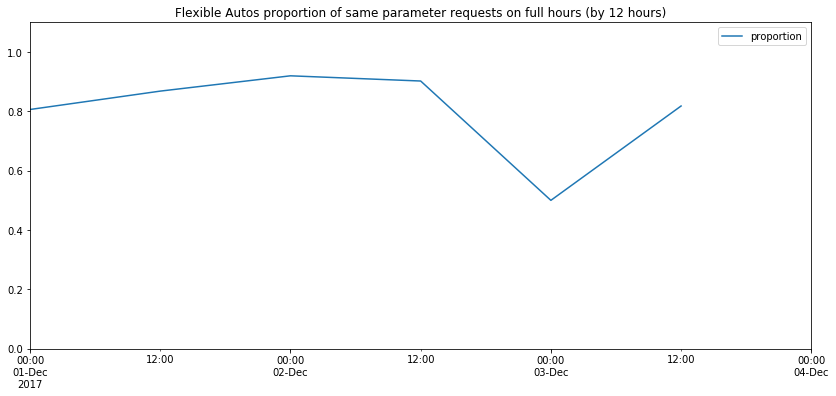

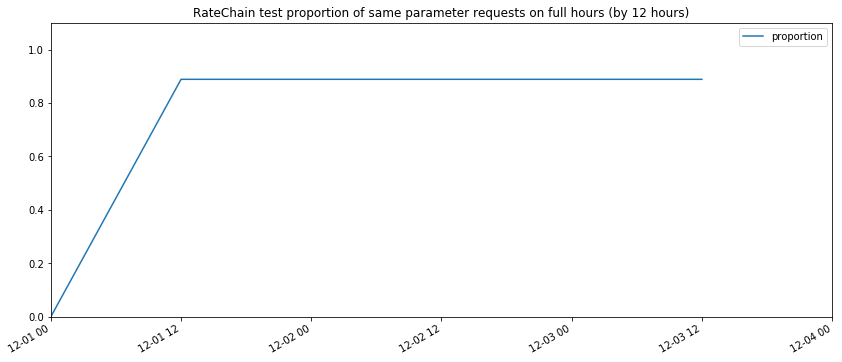

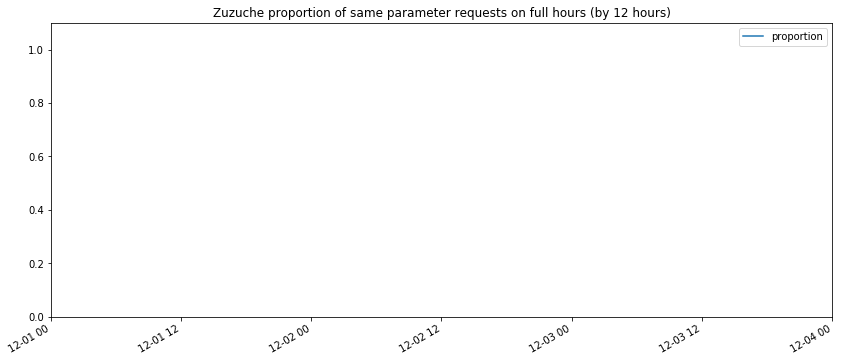

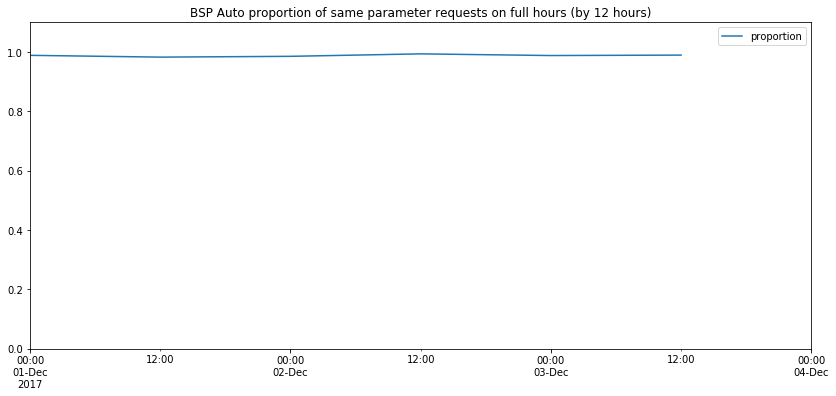

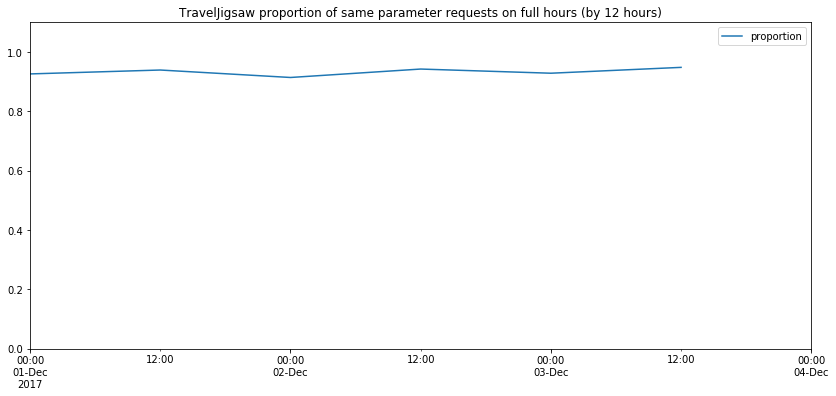

In [250]:
# 12 hours
df_new_dups_2 = df_dups.set_index("timestamp")
df_new_dups_2 = df_new_dups_2.groupby(pd.Grouper(freq='720Min'))


by_contract_id = defaultdict(list)
total = 0
by_hour = []
total_by_hour = []


for group in df_new_dups_2:
    # Group by broker_contract_id
    in_group_cache_total = 0
    for g in group[1].groupby(["broker_contract_id"]):
        non_dup = g[1].drop_duplicates(["driver_age", "source_country_region_id", "pickup_desk_id", "return_desk_id"])
        in_group_cache = len(g[1]) - len(non_dup)
        in_group_cache_total += in_group_cache
        by_contract_id[g[0]].append((group[0],in_group_cache,len(g[1])))
    by_hour.append(in_group_cache_total)
    total_by_hour.append(len(group[1]))
    total += len(group[1])
    
    

merged_data = defaultdict(dict)
for contractor in broker_contract_ids.keys():
    for key in broker_contract_ids[contractor]:
        if contractor not in merged_data:
            for i, k in enumerate(by_contract_id[key]):
                if k[0] in merged_data[contractor]:
                    merged_data[contractor][k[0]][0] += k[1]
                    merged_data[contractor][k[0]][1] += k[2]
                    
                else:
                    merged_data[contractor][k[0]] =  [k[1], k[2]]
                
        
        
        
        

for contractor in broker_contract_ids.keys():
    tJig = pd.DataFrame(merged_data[contractor]).T
    if (merged_data[contractor]):
        tJig["proportion"] = tJig[0]/tJig[1]
        tPlot = tJig.plot(y="proportion", title=contractor + " proportion of same parameter requests on full hours (by 12 hours)", kind="line")#, width=0.75)
        tPlot.set_ylim(0, 1.1)
        tPlot.set_xlim(pd.to_datetime("2017-12-01"), pd.to_datetime("2017-12-04"))


## Same pickup_timestamp and same return_timestamp

In this case we force pickup_timestamp and return_timestamp to also be the same. 

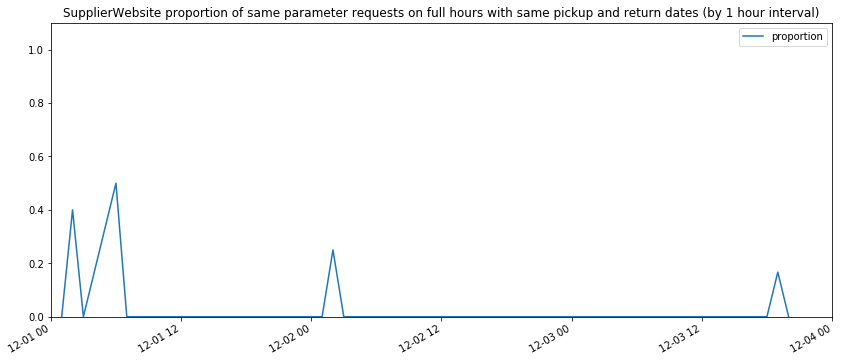

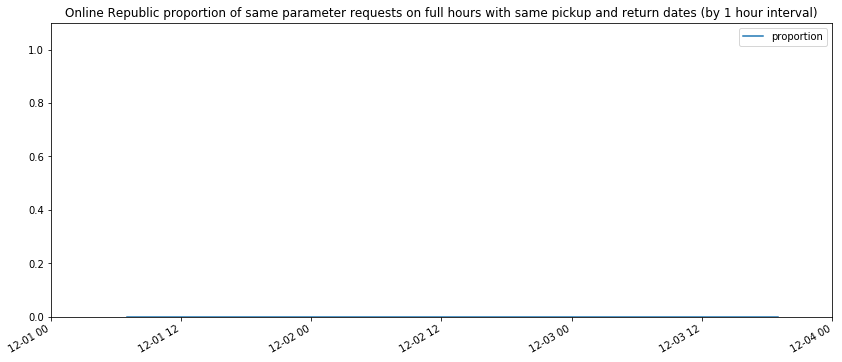

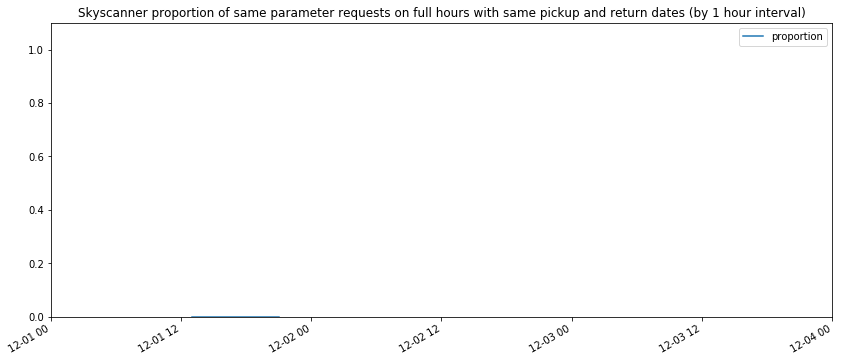

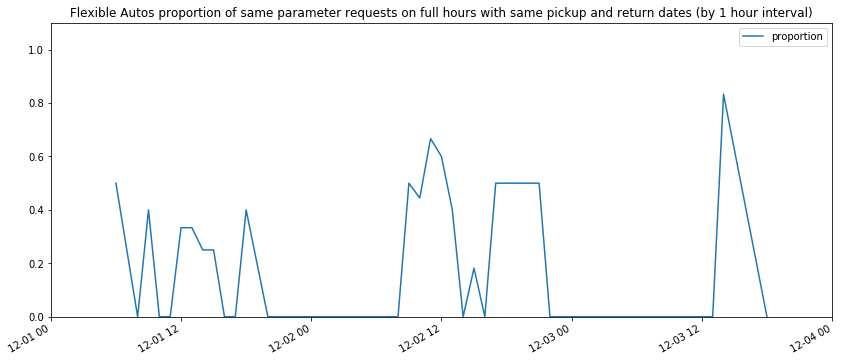

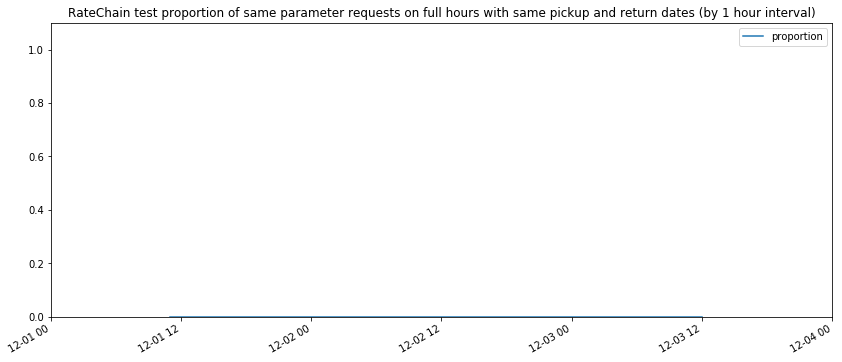

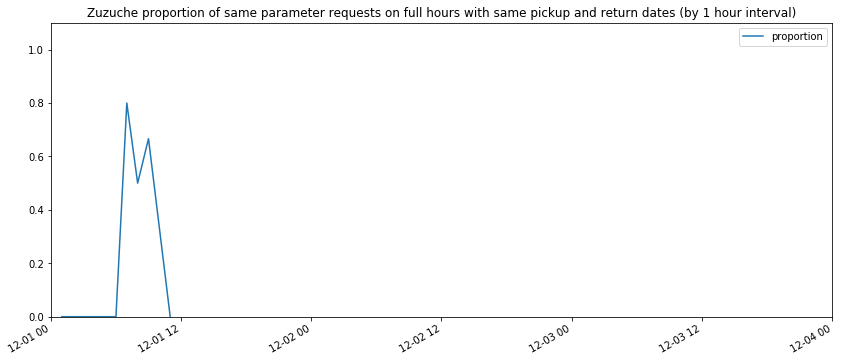

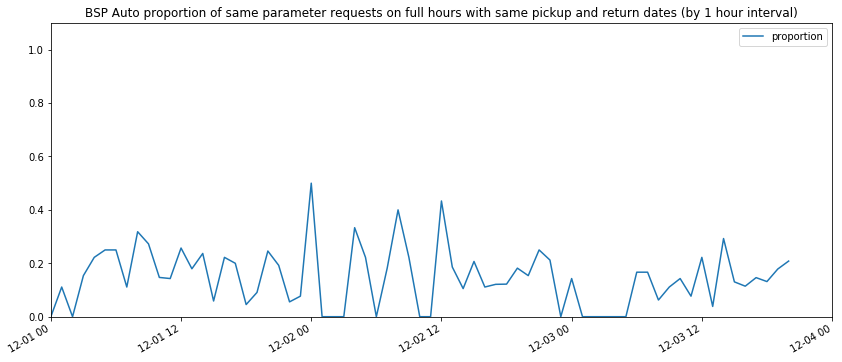

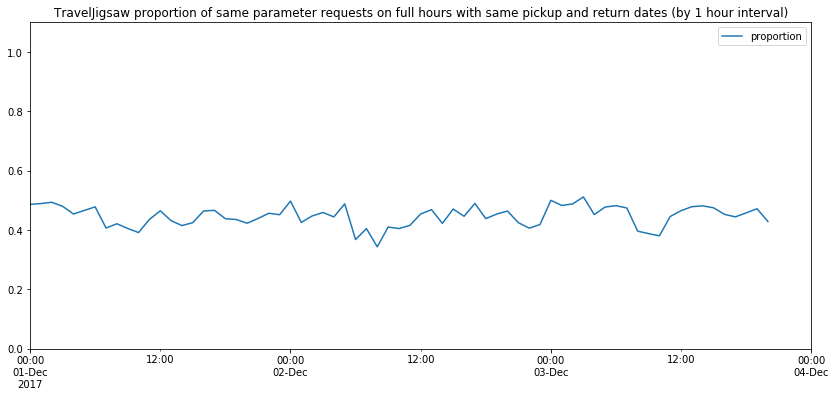

In [253]:
#2) source, pickup, return, driver age, same pickup_timestamp, same return_timestamp


# 6 hours
df_new_dups_2 = df_dups.set_index("timestamp")
df_new_dups_2 = df_new_dups_2.groupby(pd.Grouper(freq='60Min'))


by_contract_id = defaultdict(list)
total = 0
by_hour = []
total_by_hour = []


for group in df_new_dups_2:
    # Group by broker_contract_id
    in_group_cache_total = 0
    for g in group[1].groupby(["broker_contract_id"]):
        non_dup = g[1].drop_duplicates(["driver_age", "source_country_region_id", 
                                        "pickup_desk_id", "return_desk_id", "pickup_timestamp", "return_timestamp"])
        in_group_cache = len(g[1]) - len(non_dup)
        in_group_cache_total += in_group_cache
        by_contract_id[g[0]].append((group[0],in_group_cache,len(g[1])))
    by_hour.append(in_group_cache_total)
    total_by_hour.append(len(group[1]))
    total += len(group[1])
    
    

merged_data = defaultdict(dict)
for contractor in broker_contract_ids.keys():
    for key in broker_contract_ids[contractor]:
        if contractor not in merged_data:
            for i, k in enumerate(by_contract_id[key]):
                if k[0] in merged_data[contractor]:
                    merged_data[contractor][k[0]][0] += k[1]
                    merged_data[contractor][k[0]][1] += k[2]
                    
                else:
                    merged_data[contractor][k[0]] =  [k[1], k[2]]
                
        

for contractor in broker_contract_ids.keys():
    tJig = pd.DataFrame(merged_data[contractor]).T
    if (merged_data[contractor]):
        tJig["proportion"] = tJig[0]/tJig[1]
        tPlot = tJig.plot(y="proportion", title=contractor + " proportion of same parameter requests on full hours with same pickup and return dates (by 1 hour interval)", kind="line")#, width=0.75)
        tPlot.set_ylim(0, 1.1)
        tPlot.set_xlim(pd.to_datetime("2017-12-01"), pd.to_datetime("2017-12-04"))


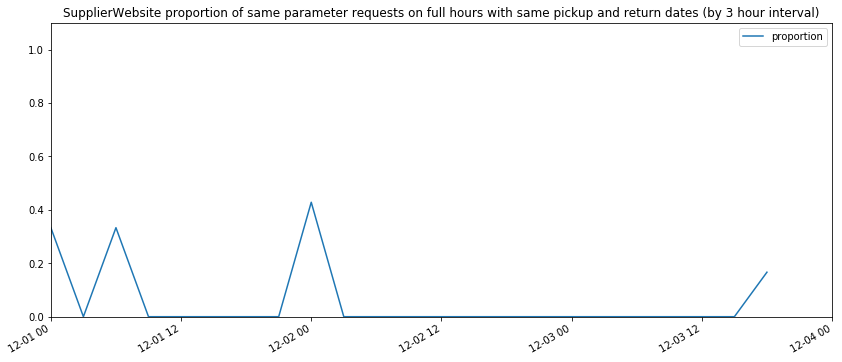

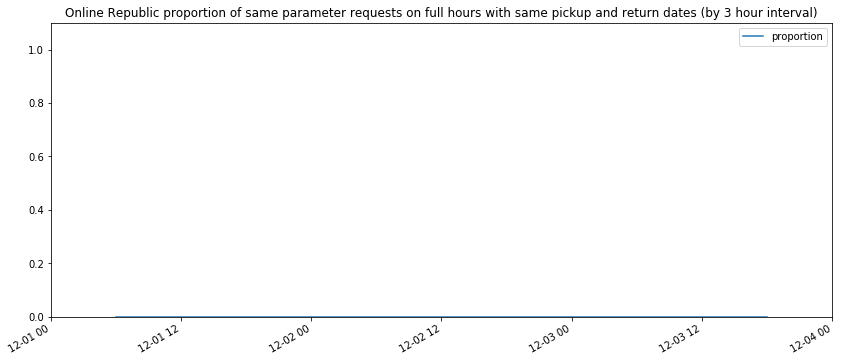

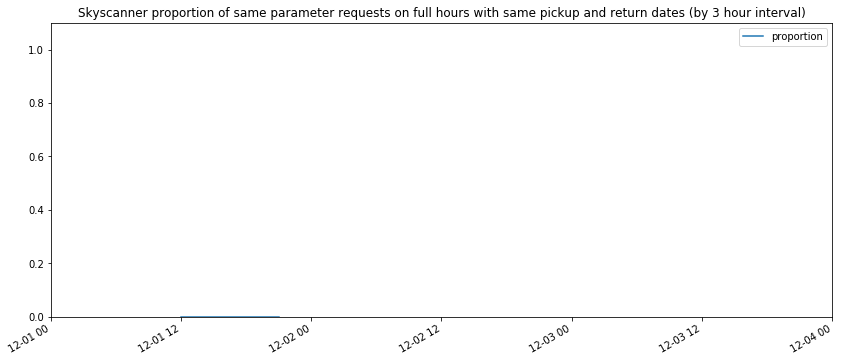

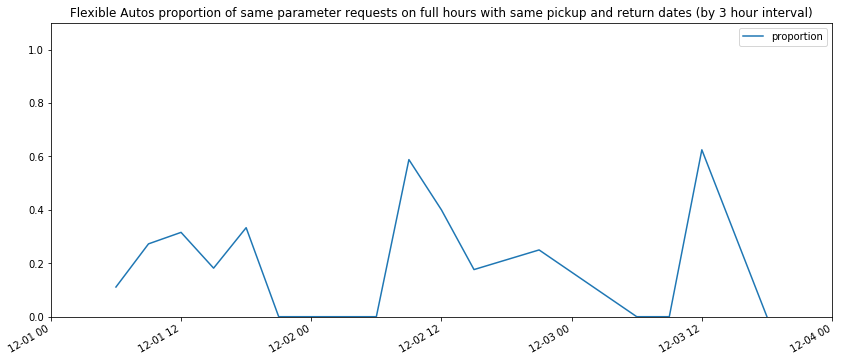

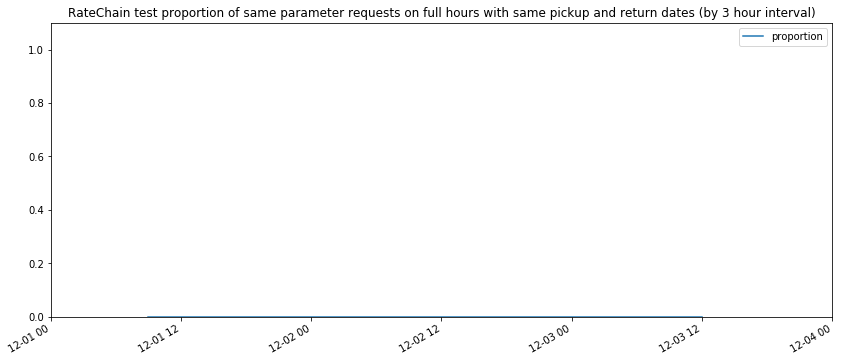

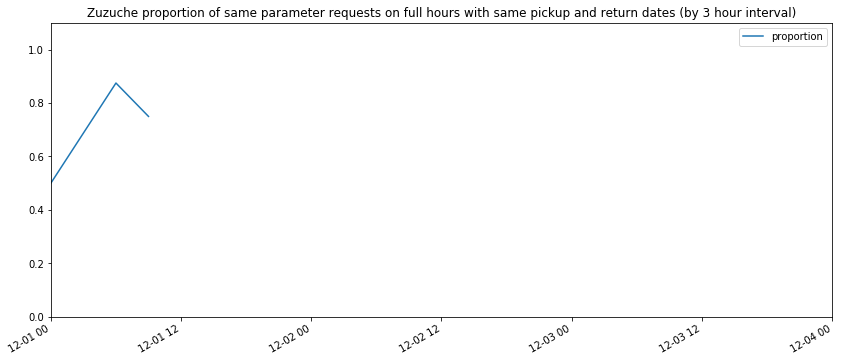

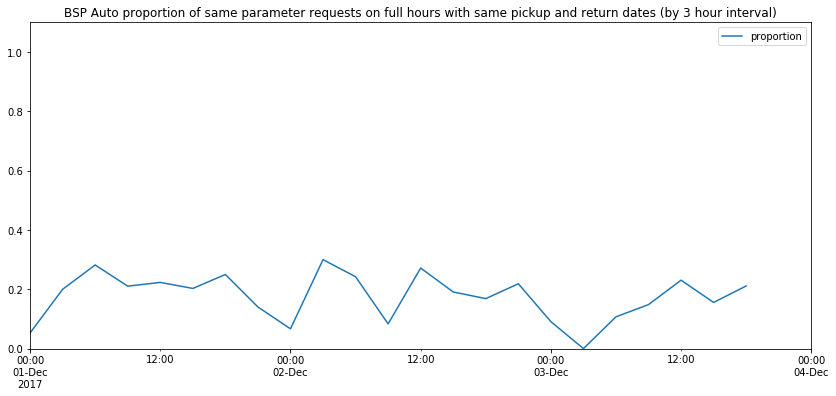

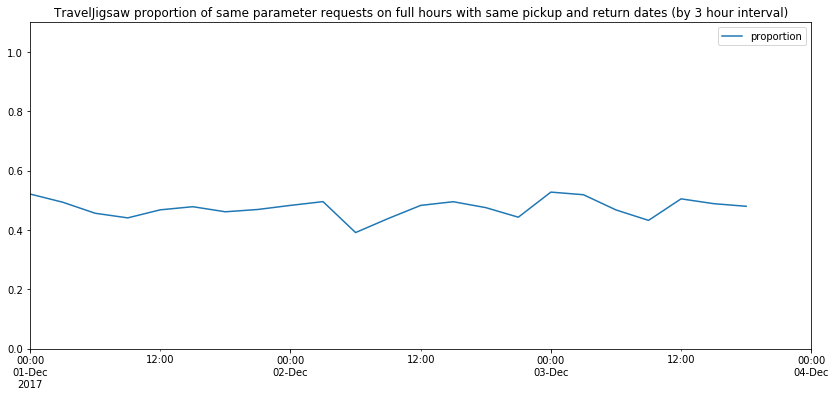

In [255]:
#2) source, pickup, return, driver age, same pickup_timestamp, same return_timestamp


# 6 hours
df_new_dups_2 = df_dups.set_index("timestamp")
df_new_dups_2 = df_new_dups_2.groupby(pd.Grouper(freq='180Min'))


by_contract_id = defaultdict(list)
total = 0
by_hour = []
total_by_hour = []


for group in df_new_dups_2:
    # Group by broker_contract_id
    in_group_cache_total = 0
    for g in group[1].groupby(["broker_contract_id"]):
        non_dup = g[1].drop_duplicates(["driver_age", "source_country_region_id", 
                                        "pickup_desk_id", "return_desk_id", "pickup_timestamp", "return_timestamp"])
        in_group_cache = len(g[1]) - len(non_dup)
        in_group_cache_total += in_group_cache
        by_contract_id[g[0]].append((group[0],in_group_cache,len(g[1])))
    by_hour.append(in_group_cache_total)
    total_by_hour.append(len(group[1]))
    total += len(group[1])
    
    

merged_data = defaultdict(dict)
for contractor in broker_contract_ids.keys():
    for key in broker_contract_ids[contractor]:
        if contractor not in merged_data:
            for i, k in enumerate(by_contract_id[key]):
                if k[0] in merged_data[contractor]:
                    merged_data[contractor][k[0]][0] += k[1]
                    merged_data[contractor][k[0]][1] += k[2]
                    
                else:
                    merged_data[contractor][k[0]] =  [k[1], k[2]]
                
        

for contractor in broker_contract_ids.keys():
    tJig = pd.DataFrame(merged_data[contractor]).T
    if (merged_data[contractor]):
        tJig["proportion"] = tJig[0]/tJig[1]
        tPlot = tJig.plot(y="proportion", title=contractor + " proportion of same parameter requests on full hours with same pickup and return dates (by 3 hour interval)", kind="line")#, width=0.75)
        tPlot.set_ylim(0, 1.1)
        tPlot.set_xlim(pd.to_datetime("2017-12-01"), pd.to_datetime("2017-12-04"))


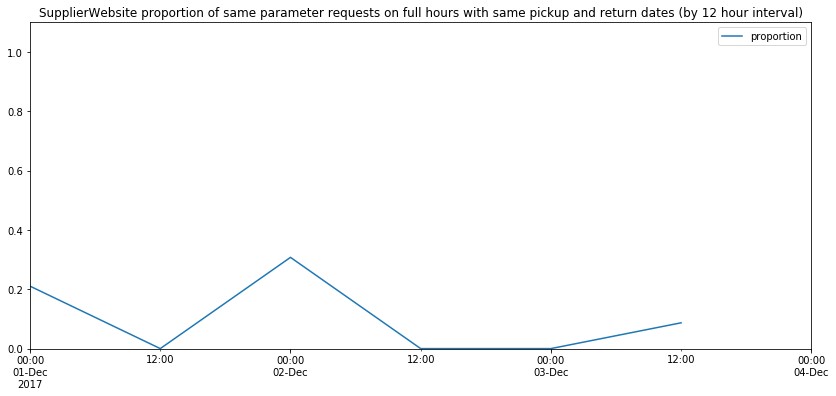

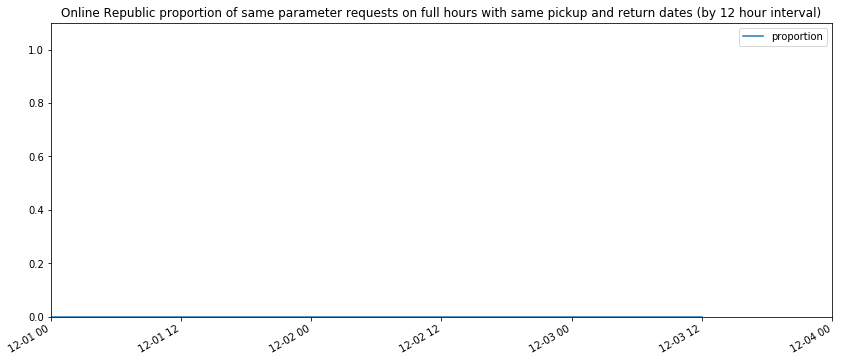

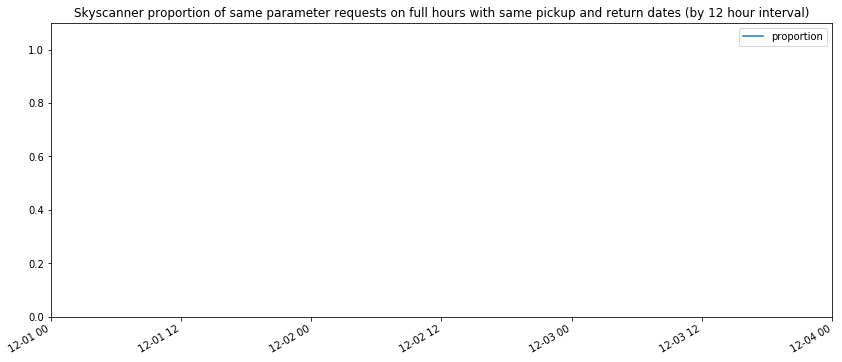

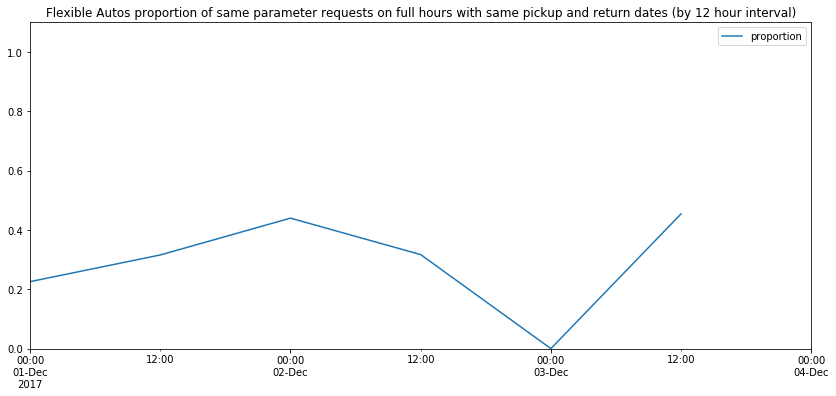

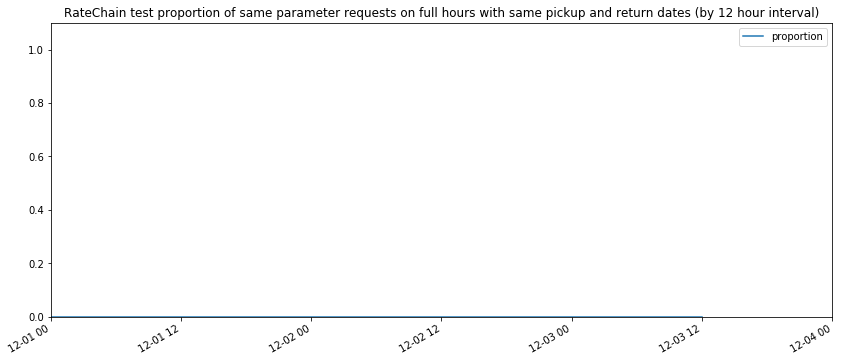

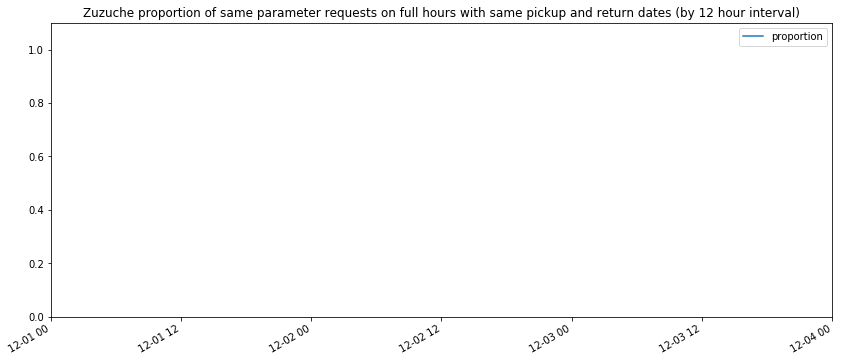

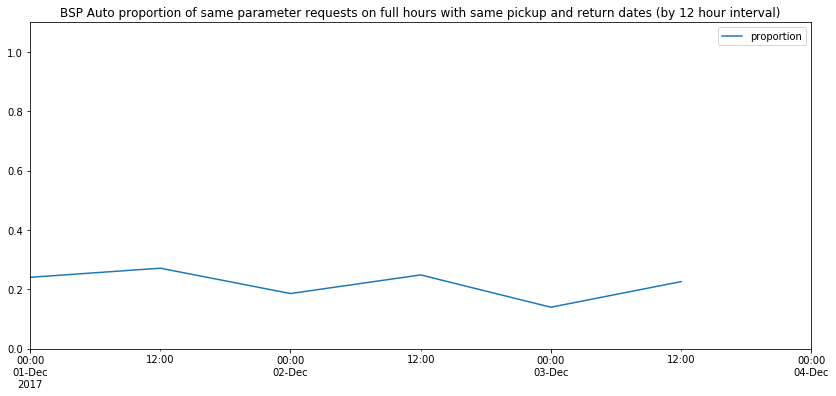

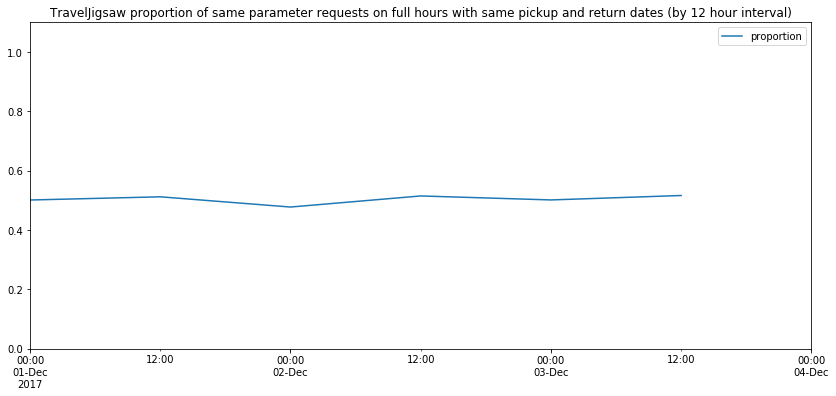

In [257]:
#2) source, pickup, return, driver age, same pickup_timestamp, same return_timestamp


# 6 hours
df_new_dups_2 = df_dups.set_index("timestamp")
df_new_dups_2 = df_new_dups_2.groupby(pd.Grouper(freq='720Min'))


by_contract_id = defaultdict(list)
total = 0
by_hour = []
total_by_hour = []


for group in df_new_dups_2:
    # Group by broker_contract_id
    in_group_cache_total = 0
    for g in group[1].groupby(["broker_contract_id"]):
        non_dup = g[1].drop_duplicates(["driver_age", "source_country_region_id", 
                                        "pickup_desk_id", "return_desk_id", "pickup_timestamp", "return_timestamp"])
        in_group_cache = len(g[1]) - len(non_dup)
        in_group_cache_total += in_group_cache
        by_contract_id[g[0]].append((group[0],in_group_cache,len(g[1])))
    by_hour.append(in_group_cache_total)
    total_by_hour.append(len(group[1]))
    total += len(group[1])
    
    

merged_data = defaultdict(dict)
for contractor in broker_contract_ids.keys():
    for key in broker_contract_ids[contractor]:
        if contractor not in merged_data:
            for i, k in enumerate(by_contract_id[key]):
                if k[0] in merged_data[contractor]:
                    merged_data[contractor][k[0]][0] += k[1]
                    merged_data[contractor][k[0]][1] += k[2]
                    
                else:
                    merged_data[contractor][k[0]] =  [k[1], k[2]]
                
        

for contractor in broker_contract_ids.keys():
    tJig = pd.DataFrame(merged_data[contractor]).T
    if (merged_data[contractor]):
        tJig["proportion"] = tJig[0]/tJig[1]
        tPlot = tJig.plot(y="proportion", title=contractor + " proportion of same parameter requests on full hours with same pickup and return dates (by 12 hour interval)", kind="line")#, width=0.75)
        tPlot.set_ylim(0, 1.1)
        tPlot.set_xlim(pd.to_datetime("2017-12-01"), pd.to_datetime("2017-12-04"))


## Three

Same pickup location, same dropoff location, same pickup day, same duration


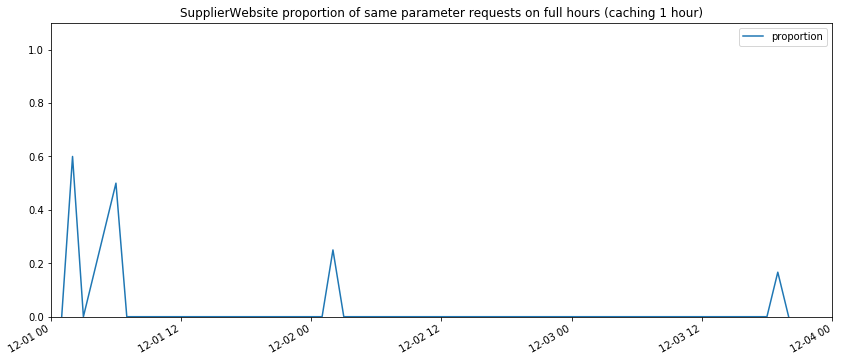

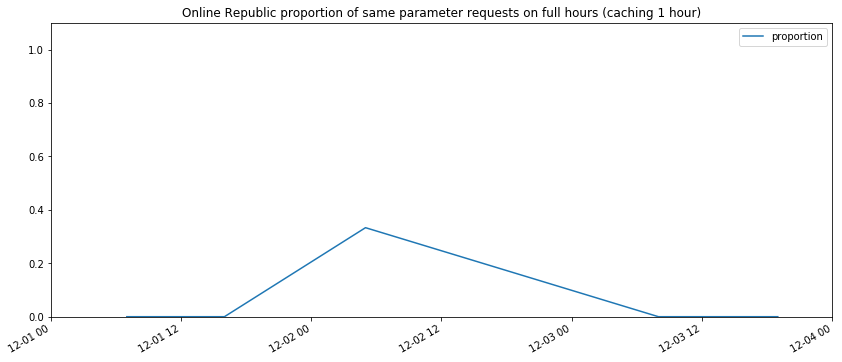

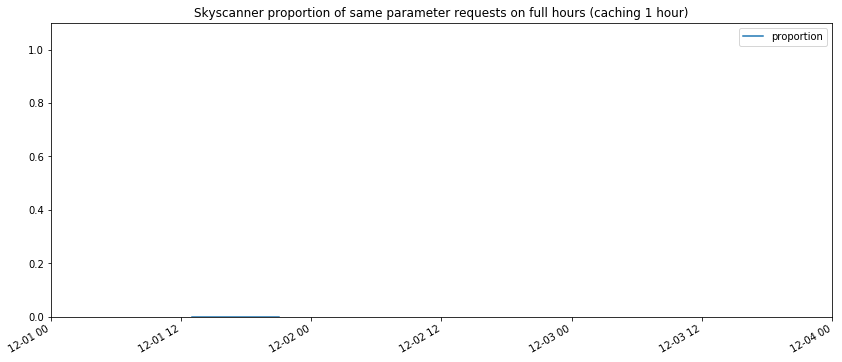

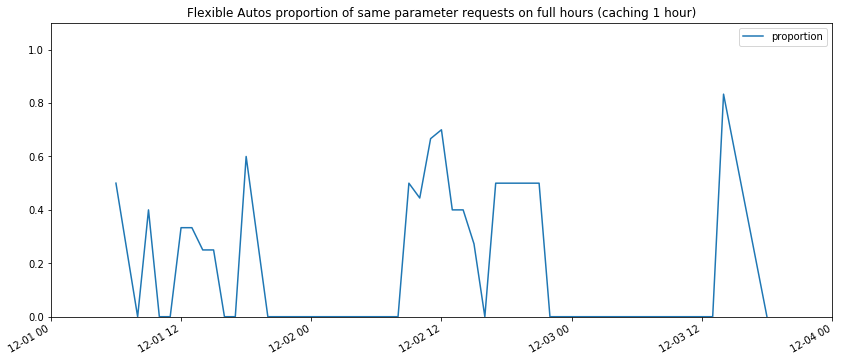

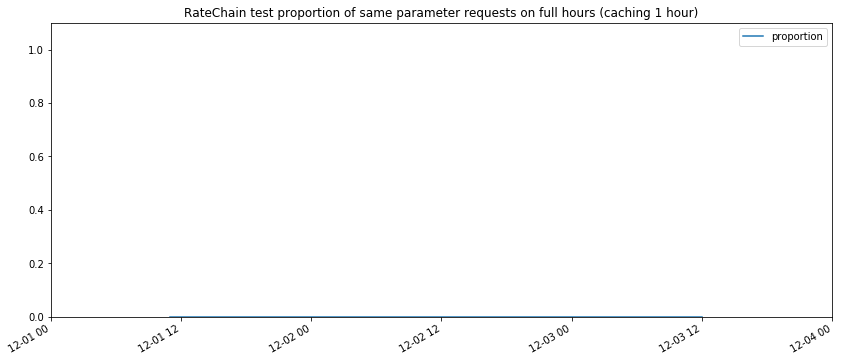

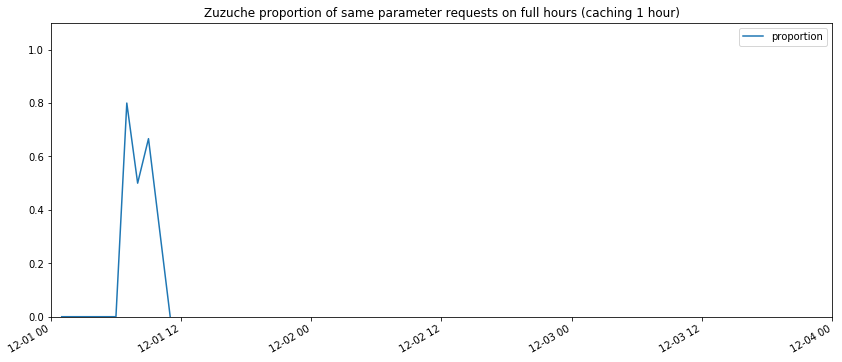

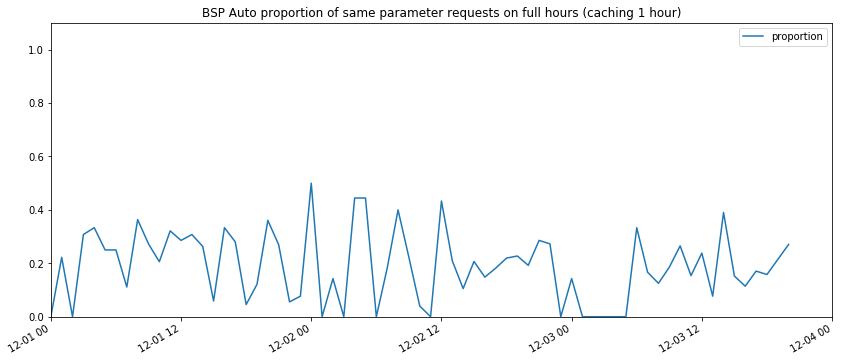

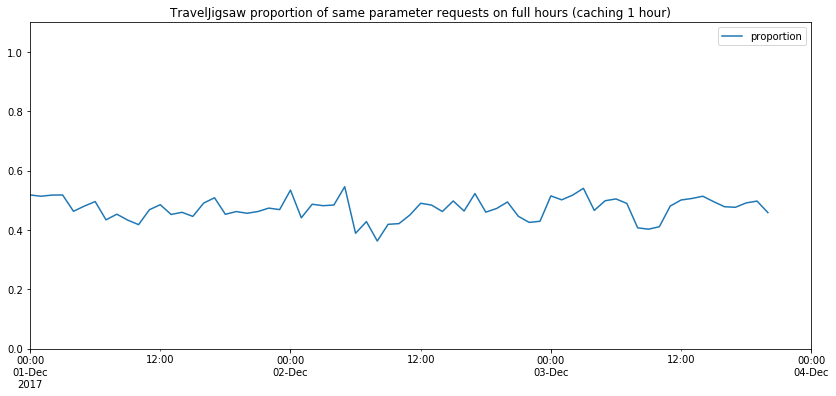

In [53]:
#2) source, pickup, return, driver age, same pickup_timestamp, same return_timestamp


# 6 hours
df_new_dups_2 = df_dups.set_index("timestamp")
df_new_dups_2["pickup_timestamp"] = df_new_dups_2["pickup_timestamp"].dt.normalize() 
df_new_dups_grouped = df_new_dups_2.groupby(pd.Grouper(freq='60Min'))

by_contract_id = defaultdict(list)
total = 0
by_hour = []
total_by_hour = []


for group in df_new_dups_grouped:
    # Group by broker_contract_id
    in_group_cache_total = 0
    for g in group[1].groupby(["broker_contract_id"]):
        non_dup = g[1].drop_duplicates(["driver_age", "source_country_region_id", 
                                        "pickup_desk_id", "return_desk_id", "pickup_timestamp", "rental_days"])
        in_group_cache = len(g[1]) - len(non_dup)
        in_group_cache_total += in_group_cache
        by_contract_id[g[0]].append((group[0],in_group_cache,len(g[1])))
    by_hour.append(in_group_cache_total)
    total_by_hour.append(len(group[1]))
    total += len(group[1])
    
    

merged_data = defaultdict(dict)
for contractor in broker_contract_ids.keys():
    for key in broker_contract_ids[contractor]:
        if contractor not in merged_data:
            for i, k in enumerate(by_contract_id[key]):
                if k[0] in merged_data[contractor]:
                    merged_data[contractor][k[0]][0] += k[1]
                    merged_data[contractor][k[0]][1] += k[2]
                    
                else:
                    merged_data[contractor][k[0]] =  [k[1], k[2]]
                
        

for contractor in broker_contract_ids.keys():
    tJig = pd.DataFrame(merged_data[contractor]).T
    if (merged_data[contractor]):
        tJig["proportion"] = tJig[0]/tJig[1]
        tPlot = tJig.plot(y="proportion", title=contractor + " proportion of same parameter requests on full hours (caching 1 hour)", kind="line")
        tPlot.set_ylim(0, 1.1)
        tPlot.set_xlim(pd.to_datetime("2017-12-01"), pd.to_datetime("2017-12-04"))


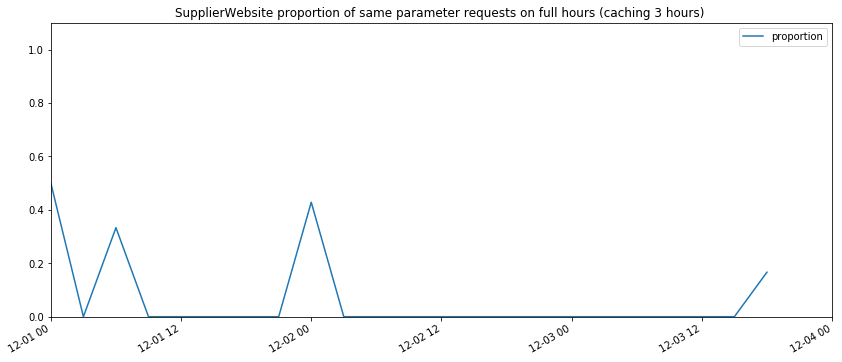

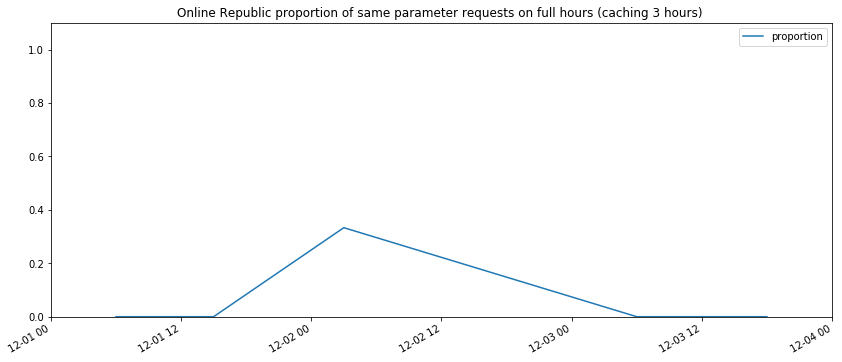

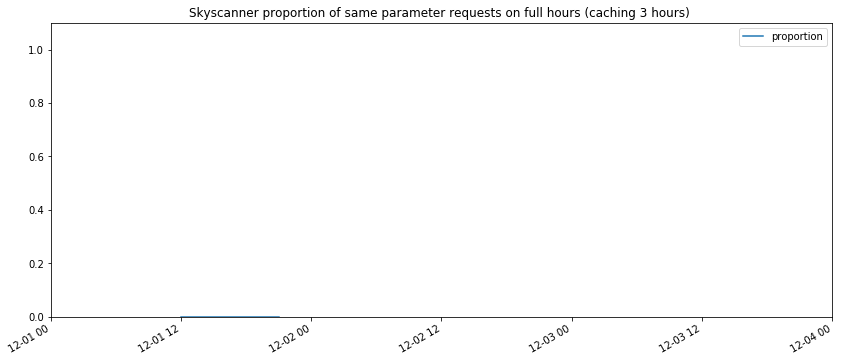

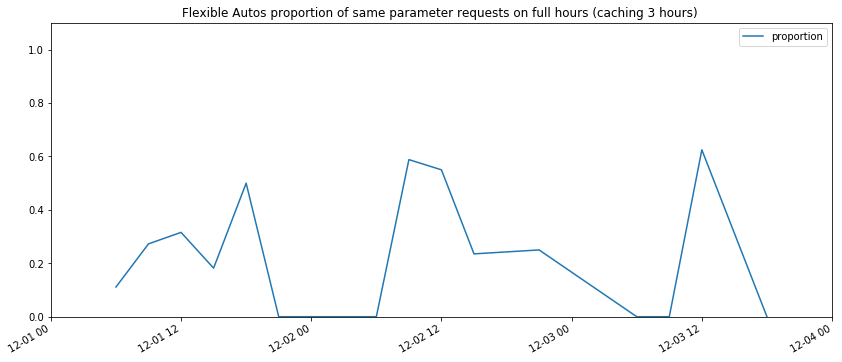

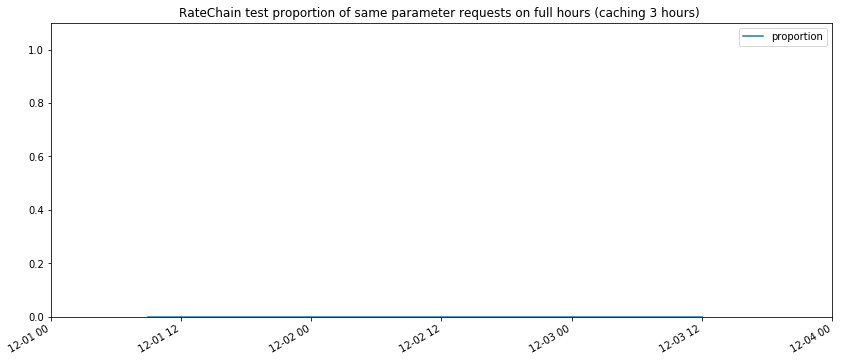

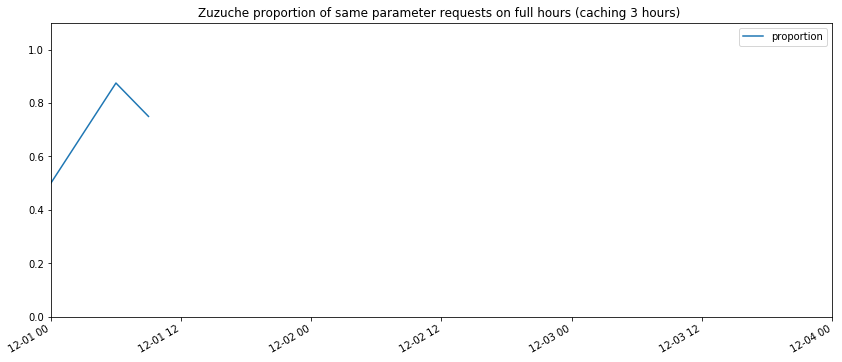

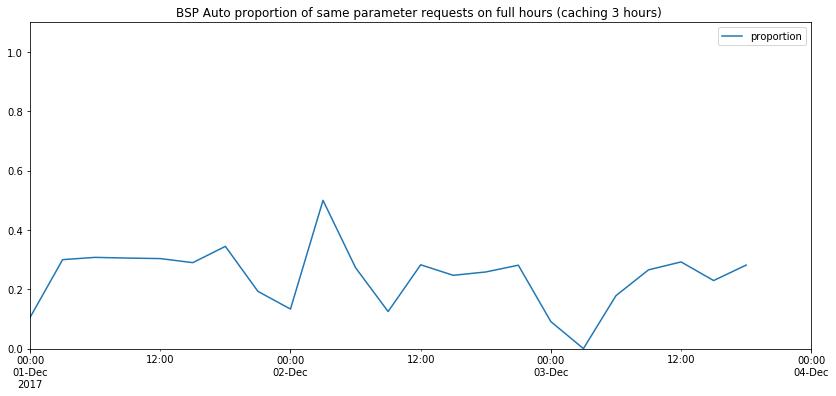

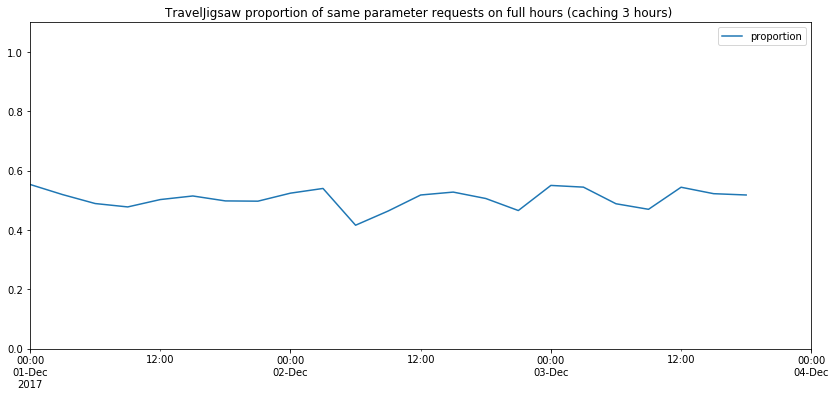

In [54]:
#2) source, pickup, return, driver age, same pickup_timestamp, same return_timestamp


# 3 hours
df_new_dups_2 = df_dups.set_index("timestamp")
df_new_dups_2["pickup_timestamp"] = df_new_dups_2["pickup_timestamp"].dt.normalize()
#print(df_new_dups_2)
df_new_dups_grouped = df_new_dups_2.groupby(pd.Grouper(freq='180Min'))

by_contract_id = defaultdict(list)
total = 0
by_hour = []
total_by_hour = []


for group in df_new_dups_grouped:
    # Group by broker_contract_id
    in_group_cache_total = 0
    for g in group[1].groupby(["broker_contract_id"]):
        non_dup = g[1].drop_duplicates(["driver_age", "source_country_region_id", 
                                        "pickup_desk_id", "return_desk_id", "pickup_timestamp", "rental_days"])
        in_group_cache = len(g[1]) - len(non_dup)
        in_group_cache_total += in_group_cache
        by_contract_id[g[0]].append((group[0],in_group_cache,len(g[1])))
    by_hour.append(in_group_cache_total)
    total_by_hour.append(len(group[1]))
    total += len(group[1])
    
    

merged_data_2 = defaultdict(dict)
for contractor in broker_contract_ids.keys():
    for key in broker_contract_ids[contractor]:
        if contractor not in merged_data_2:
            for i, k in enumerate(by_contract_id[key]):
                if k[0] in merged_data_2[contractor]:
                    merged_data_2[contractor][k[0]][0] += k[1]
                    merged_data_2[contractor][k[0]][1] += k[2]
                    
                else:
                    merged_data_2[contractor][k[0]] =  [k[1], k[2]]
                
        

for contractor in broker_contract_ids.keys():
    tJig = pd.DataFrame(merged_data_2[contractor]).T
    if (merged_data_2[contractor]):
        tJig["proportion"] = tJig[0]/tJig[1]
        tPlot = tJig.plot(y="proportion", title=contractor + " proportion of same parameter requests on full hours (caching 3 hours) ", kind="line")#, width=0.75)
        tPlot.set_ylim(0, 1.1)
        tPlot.set_xlim(pd.to_datetime("2017-12-01"), pd.to_datetime("2017-12-04"))


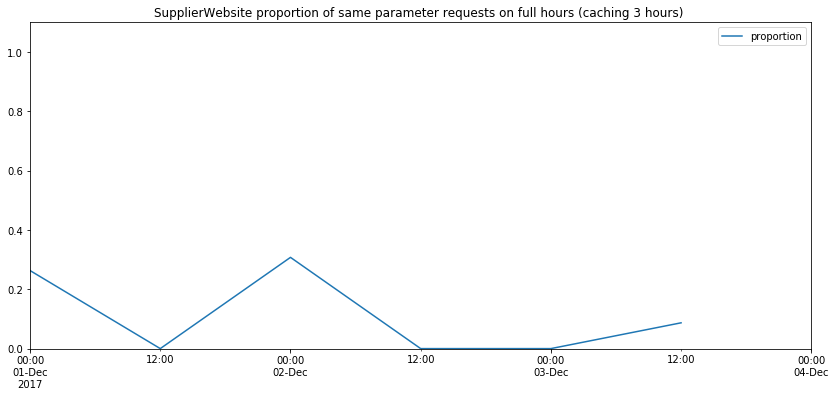

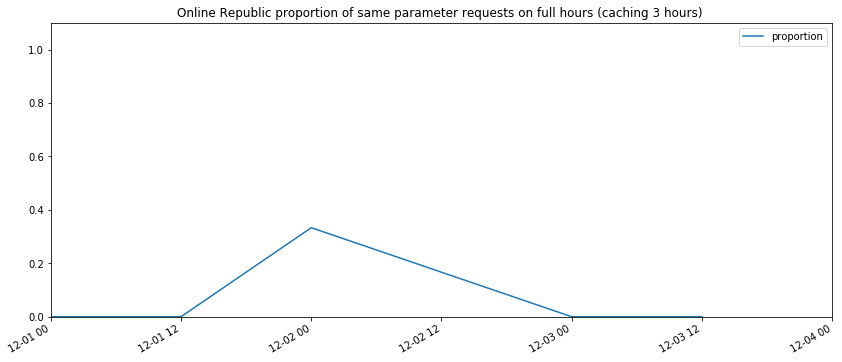

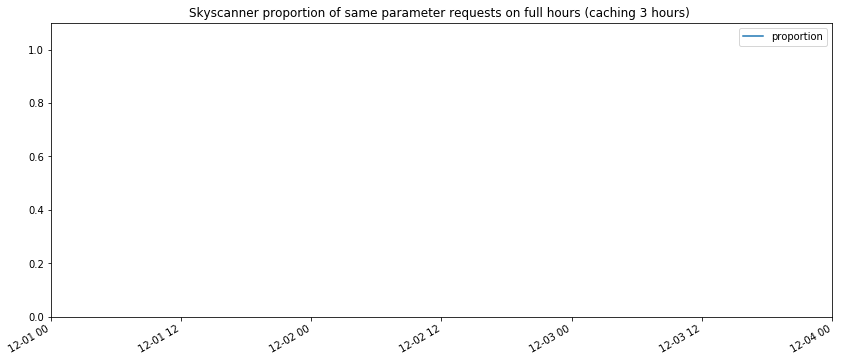

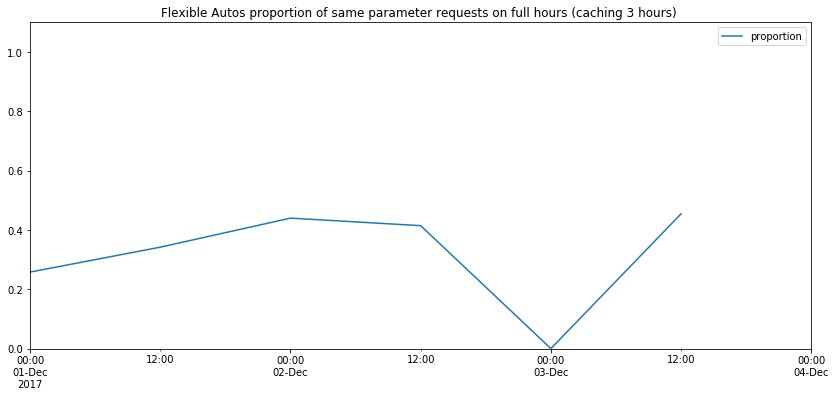

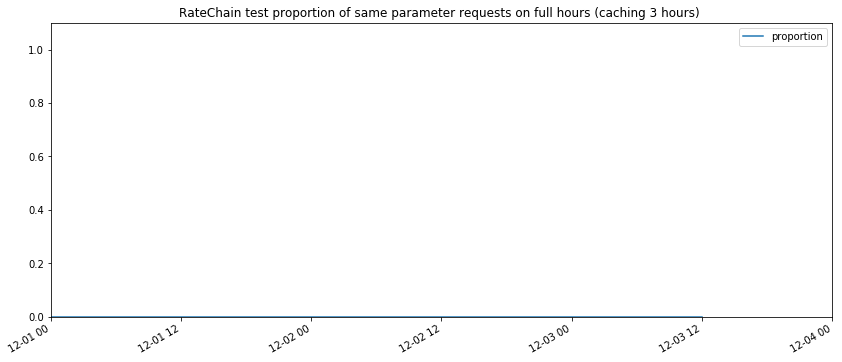

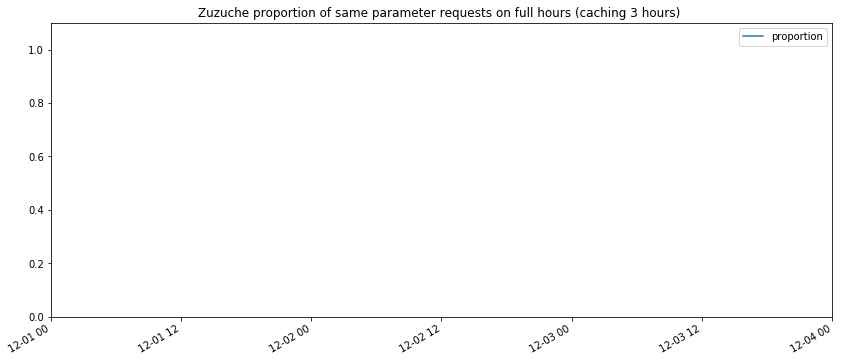

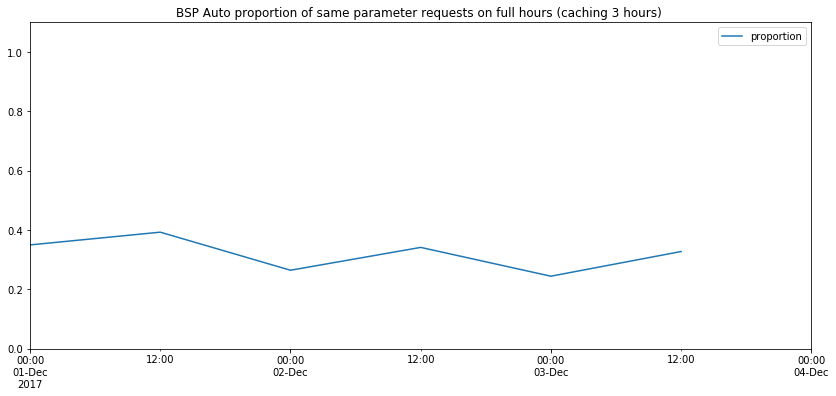

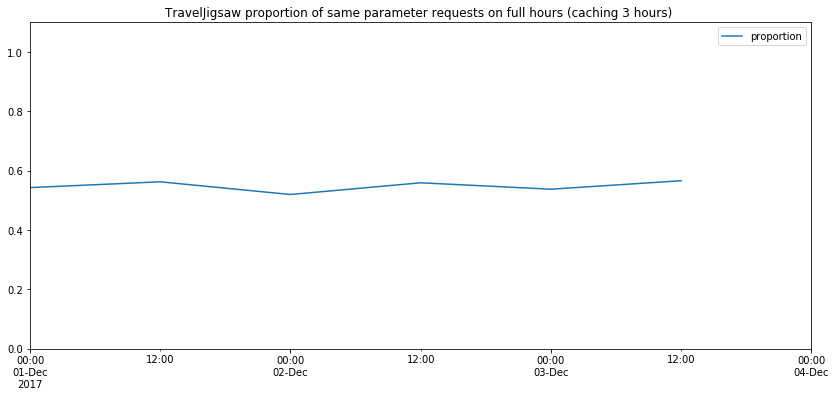

In [55]:
#2) source, pickup, return, driver age, same pickup_timestamp, same return_timestamp


# 3 hours
df_new_dups_2 = df_dups.set_index("timestamp")
df_new_dups_2["pickup_timestamp"] = df_new_dups_2["pickup_timestamp"].dt.normalize()
#print(df_new_dups_2)
df_new_dups_grouped = df_new_dups_2.groupby(pd.Grouper(freq='720Min'))

by_contract_id = defaultdict(list)
total = 0
by_hour = []
total_by_hour = []


for group in df_new_dups_grouped:
    # Group by broker_contract_id
    in_group_cache_total = 0
    for g in group[1].groupby(["broker_contract_id"]):
        non_dup = g[1].drop_duplicates(["driver_age", "source_country_region_id", 
                                        "pickup_desk_id", "return_desk_id", "pickup_timestamp", "rental_days"])
        in_group_cache = len(g[1]) - len(non_dup)
        in_group_cache_total += in_group_cache
        by_contract_id[g[0]].append((group[0],in_group_cache,len(g[1])))
    by_hour.append(in_group_cache_total)
    total_by_hour.append(len(group[1]))
    total += len(group[1])
    
    

merged_data_3 = defaultdict(dict)
for contractor in broker_contract_ids.keys():
    for key in broker_contract_ids[contractor]:
        if contractor not in merged_data_3:
            for i, k in enumerate(by_contract_id[key]):
                if k[0] in merged_data_3[contractor]:
                    merged_data_3[contractor][k[0]][0] += k[1]
                    merged_data_3[contractor][k[0]][1] += k[2]
                    
                else:
                    merged_data_3[contractor][k[0]] =  [k[1], k[2]]
                
        

for contractor in broker_contract_ids.keys():
    tJig = pd.DataFrame(merged_data_3[contractor]).T
    if (merged_data_3[contractor]):
        tJig["proportion"] = tJig[0]/tJig[1]
        tPlot = tJig.plot(y="proportion", title=contractor + " proportion of same parameter requests on full hours (caching 3 hours) ", kind="line")#, width=0.75)
        tPlot.set_ylim(0, 1.1)
        tPlot.set_xlim(pd.to_datetime("2017-12-01"), pd.to_datetime("2017-12-04"))


In [129]:
#2) source, pickup, return, driver age, same pickup_timestamp, same return_timestamp




df_new_dups_2 = df_dups.set_index("timestamp")
df_new_dups_2["pickup_timestamp"] = df_new_dups_2["pickup_timestamp"].dt.normalize()

merged_datas = []


for frq in [60,180,720]:
    merged_data_3 = defaultdict(dict)
    for contractor in broker_contract_ids.keys():
        df_contractor = df_new_dups_2[df_new_dups_2["Broker_name"] == contractor]
        if not df_contractor.empty:
            df_contractor = df_contractor.sort_index()
            date_range = pd.date_range(df_contractor.index.min(), df_contractor.index.max(), freq="30Min")
            cum_total = 0
            for i in range(len(date_range)-1):
                between_dates = df_contractor[date_range[i+1]-pd.Timedelta(minutes=frq):date_range[i+1]]
                total = len(between_dates)
                non_dup_count = len(between_dates.drop_duplicates(["driver_age", "source_country_region_id", "broker_contract_id",
                                                    "pickup_desk_id", "return_desk_id", "pickup_timestamp", "rental_days"]))
                cached = total - non_dup_count
                proportion = 0 if total == 0 else cached/total
                cum_total += total
                merged_data_3[contractor][date_range[i+1]] = [cached, total, proportion, cum_total]
                
                
    merged_datas.append(merged_data_3)
    
    
    
    

In [10]:
#import plotly.plotly as py
#import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go


In [8]:
init_notebook_mode()

In [114]:
for broker in broker_contract_ids.keys():
    tJigs = []
    for merged_data in merged_datas:
        tJig = pd.DataFrame(merged_data[broker]).T
        if tJig.empty:
            continue
        tJig["proportion"] = tJig[2]
        tJigs.append(tJig)


    layout = go.Layout(
        title = broker + " proportion of same parameter requests",
        titlefont=dict(
                family='Courier New, monospace'
        ),
        xaxis=dict(
            showgrid=True,
            zeroline=True,
            showline=True,
            #ticks='',
            showticklabels=True,
            title="Date",
        ),
        yaxis=dict(
            showgrid=True,
            zeroline=True,
            showline=True,
            #ticks='',
            showticklabels=True,
            range = [0,1],
            title="Proportion of cacheable requests"
        )
    )
    try:
        data = [go.Scatter(x=tJigs[0].index, y=tJigs[0].proportion, name="Caching 1 hour"), 
                go.Scatter(x=tJigs[1].index, y=tJigs[1].proportion, name="Caching 3 hours"), 
                go.Scatter(x=tJigs[2].index, y=tJigs[2].proportion, name="Caching 12 hours")]
    except:
        pass
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [135]:
fields = ["Contract_ID", "Contract_name", "Broker name"]
contract_df = pd.read_csv("broker_contracts.csv", skipinitialspace=True, usecols=fields)
contract_df["Broker name"] = contract_df["Broker name"].astype(str)
contract_df["Contract_name"] = contract_df["Contract_name"].astype(str)
# This holds contract names and which broker name corresponds to each contract id..
#contract_df = contract_df.set_index("Contract_ID")

print(contract_df.shape)
print(contract_df.dtypes)


# What different contractors are there?
contractors = set(contract_df["Broker name"])
print("Different contractors:", contractors)

# For broker, find which contract ids it has
from collections import defaultdict

broker_contract_ids = defaultdict(set)
for row in contract_df.itertuples():
    broker_contract_ids[row[3]].add(row[0])


contract_df.columns = ["broker_contract_id", "Contract_name", "Broker_name"]
    
#print(df)
    
    
merged_requests = pd.merge(df, contract_df, on=["broker_contract_id"])

print(merged_requests.dtypes)
# Create new, merged table, with contractor name in each.

(27, 3)
Contract_ID       int64
Contract_name    object
Broker name      object
dtype: object
Different contractors: {'SupplierWebsite', 'FTI', 'CarTrawler', 'Clarify Car Hire', 'TravelJigsaw', 'Online Republic', 'Atlantic Choice', 'Flexible Autos', 'BSP Auto', 'Skyscanner', 'Zuzuche', 'CDM-AE-CR', 'RateChain test'}
timestamp                   object
pickup_desk_id               int64
return_desk_id               int64
pickup_timestamp            object
rental_days                  int64
broker_contract_id           int64
source_country_region_id     int64
driver_age                   int64
Contract_name               object
Broker_name                 object
dtype: object


In [142]:
#2) source, pickup, return, driver age, same pickup_timestamp, same return_timestamp
merged_requests["timestamp"] = pd.to_datetime(merged_requests['timestamp'])
merged_requests["pickup_timestamp"] = pd.to_datetime(merged_requests['pickup_timestamp'])

df_new_dups_2 = merged_requests.set_index("timestamp")
df_new_dups_2["pickup_timestamp"] = df_new_dups_2["pickup_timestamp"].dt.normalize()

merged_datas = []

for frq in [60,180,720]:
    merged_data_3 = defaultdict(dict)
    for contractor in broker_contract_ids.keys():
        df_contractor = df_new_dups_2[df_new_dups_2["Broker_name"] == contractor]
        if not df_contractor.empty:
            df_contractor = df_contractor.sort_index()
            date_range = pd.date_range(df_contractor.index.min(), df_contractor.index.max(), freq="30Min")
            cum_total = 0
            for i in range(len(date_range)-1):
                between_dates = df_contractor[date_range[i+1]-pd.Timedelta(minutes=frq):date_range[i+1]]
                total = len(between_dates)
                non_dup_count = len(between_dates.drop_duplicates(["driver_age", "source_country_region_id", "broker_contract_id",
                                                    "pickup_desk_id", "return_desk_id", "pickup_timestamp", "rental_days"]))
                cached = total - non_dup_count
                proportion = 0 if total == 0 else cached/total
                cum_total += total
                merged_data_3[contractor][date_range[i+1]] = [cached, total, proportion, cum_total]
                
                
    merged_datas.append(merged_data_3)
    
    
    
    

In [141]:
for broker in broker_contract_ids.keys():
    tJigs = []
    for merged_data in merged_datas:
        tJig = pd.DataFrame(merged_data[broker]).T
        if tJig.empty:
            continue
        tJigs.append(tJig)


    layout = go.Layout(
        title = broker + " absolute number of cacheable requests",
        titlefont=dict(
                family='Courier New, monospace'
        ),
        xaxis=dict(
            showgrid=True,
            zeroline=True,
            showline=True,
            #ticks='',
            showticklabels=True,
            title="Date",
        ),
        yaxis=dict(
            showgrid=True,
            zeroline=True,
            showline=True,
            #ticks='',
            showticklabels=True,
            #range = [0,1],
            title="Absolute count of cacheable requests"
        )
    )
    data = []
    try:
        data = [go.Scatter(x=tJigs[0].index, y=tJigs[0][0], name="Caching 1 hour"), 
                go.Scatter(x=tJigs[1].index, y=tJigs[1][0], name="Caching 3 hours"), 
                go.Scatter(x=tJigs[2].index, y=tJigs[2][0], name="Caching 12 hours")]
        
    except:
        pass
    if data:
        fig = go.Figure(data=data, layout=layout)
        iplot(fig)
